In [40]:
import argparse
from pathlib import Path
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
from matplotlib.colors import ListedColormap
import scienceplots
import pandas as pd
import json
from pprint import pprint
import seaborn as sns
import torch

import torchmetrics
from torchmetrics import PrecisionRecallCurve, ROC
from torchmetrics.functional.classification import binary_auroc, multiclass_auroc, binary_precision_recall_curve, multiclass_precision_recall_curve, confusion_matrix
from torchmetrics.functional.classification import binary_accuracy, multiclass_accuracy, binary_recall, binary_precision, multiclass_recall, multiclass_precision, binary_f1_score, multiclass_f1_score
from torchmetrics.utilities.compute import _auc_compute_without_check, _auc_compute

from utils.utils import get_roc_curve, get_pr_curve, get_confusion_matrix, get_optimal_operating_point

from scipy.stats import bootstrap as scp_bootstrap
from sklearn.metrics import roc_auc_score

import statistics
import logging

from cycler import cycler

In [29]:
def bootstrap(y_pred, y_true, n):
    rng_seed = 42
    bootstrapped_scores = []
    bootstrapped_accuracy = []
    n_classes = 1
    if len(y_pred.shape) > 1:
        n_classes = y_pred.shape[1]
    # rng = np.random.RandomState(rng_seed=4)
    for i in range(n):
        # bootstrap by sampling with replacement on the prediction indices
        indices = torch.randint(low=0, high=len(y_true), size=(len(y_true), ))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        if len(y_pred.shape) > 1:
            score = multiclass_auroc(y_pred[indices], y_true[indices], num_classes=n_classes, average=None)
        else: 
            score = binary_auroc(y_pred[indices], y_true[indices])

        bootstrapped_scores.append(score)

    if n_classes > 1:
        for i in range(n_classes):
            # print('Class ', i)

            sub_array = [x[i] for x in bootstrapped_scores]
            # print(sub_array)
            sorted_scores = np.array(sub_array)
            sorted_scores.sort()

        # Computing the lower and upper bound of the 90% confidence interval
        # You can change the bounds percentiles to 0.025 and 0.975 to get
        # a 95% confidence interval instead.
            confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
            confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]


            # print("n={} Confidence interval for the score: [{:0.3f} - {:0.3}]".format(n,
            # confidence_lower, confidence_upper))

            # print('MEAN: ', np.mean(sorted_scores))
            # print('MEDIAN: ', statistics.median(sorted_scores))

        mean_array = [torch.mean(x) for x in bootstrapped_scores]

        sorted_scores = np.array(mean_array)
        sorted_scores.sort()

        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]


        # print("n={} MEAN Confidence interval for the score: {:0.3f}".format(n,
        # confidence_lower, confidence_upper))
        
    else:

        sorted_scores = np.array(bootstrapped_scores)
        
        sorted_scores.sort()
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

        # print("n={} Confidence interval for the score: [{:0.3f} - {:0.3}]".format(n,
        # confidence_lower, confidence_upper))

        # print('MEAN: ', np.mean(sorted_scores))
        # print('MEDIAN: ', statistics.median(sorted_scores))
    
    return np.mean(sorted_scores), (confidence_lower, confidence_upper)

In [30]:
ktx_dict = {
    'TransMIL': {
        # 'norm_rest': {'version': '893', 'epoch': '166', 'labels':['Normal', 'Disease']},
        # 'norm_rest': {'version': '804', 'epoch': '30', 'labels':['Normal', 'Disease']},
        # 'rest_rej': {'version': '63', 'epoch': '14', 'labels': ['Rest', 'Rejection']},
        'norm_rej_rest': {'version': '53', 'epoch': '17', 'labels': ['Normal', 'Rejection', 'Rest']},
    },
    'CLAM': {
        # 'norm_rest': {'labels':['NORMAL', 'REST']},
        # 'rej_rest': {'labels': ['REJECTION', 'REST']},
        'norm_rej_rest': {'version': '', 'epoch': '', 'labels': ['NORMAL', 'REJECTION', 'REST']},
    },
    'ViT': {
        # 'norm_rest': {'version': '16', 'epoch': '142', 'labels':['Normal', 'Disease']},
        # 'rej_rest': {'version': '1', 'epoch': 'last', 'labels': ['Rejection', 'Rest']},
        'norm_rej_rest': {'version': '0', 'epoch': '226', 'labels': ['Normal', 'Rejection', 'Rest']},
    },
    
    'Inception': {
        # 'norm_rest': {'labels':['Normal', 'Disease']},
        # 'rest_rej': {'labels': ['Rest', 'Rejection']},
        'norm_rej_rest': {'version': '', 'epoch': '', 'labels': ['Normal', 'Rejection', 'Rejection']},
    }
}

rcc_dict = {
    'TransMIL':{
        'big_three': {'version': '14', 'epoch':'244', 'labels':['ccRCC', 'papRCC', 'chRCC']}
    },
    'CLAM':{
        'big_three': {'labels':['ccRCC', 'papRCC', 'chRCC']}
    },
    'Inception': {
        'big_three': {'version': '2', 'epoch': '79', 'labels':['ccRCC', 'papRCC', 'chRCC']}
    },
    'ViT': {
        'big_three': {'version': '4', 'epoch': '27', 'labels': ['ccRCC', 'papRCC', 'chRCC']}
    },
}

In [31]:
def generate_plots(project, model, t, version=None, epoch=None, labels=None, add_on=0):

    # print('-----------------------------------------------------------------------')
    # print(project, model, t, f'v{version}', f'e{epoch}', labels, add_on)
    # print('-----------------------------------------------------------------------')

    if project == 'DeepGraft':

        if model == 'CLAM':
            patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/HIA/logs/DeepGraft_Lancet/clam_mb/DEEPGRAFT_CLAMMB_TRAINFULL_{t}/RESULTS/TEST_RESULT_PATIENT_BASED_FULL.csv')
            threshold_csv_path = ''
        elif model == 'Inception':
            patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
            # test/inception_results/rest_rej.csv
            # Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
        else: 
            #TransMIL and ViT
            if model == 'TransMIL':
                a = 'features'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/DeepGraft/{model}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}_best'
            else:
                a = 'vit'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/DeepGraft/{a}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'

            
            # print(root_dir)
            patient_result_csv_path = Path(root_dir) / 'TEST_RESULT_PATIENT.csv'
            # print(patient_result_csv_path)
            threshold_csv_path = f'{root_dir}/val_thresholds.csv'
            thresh_df = pd.read_csv(threshold_csv_path, index_col=False)
            optimal_threshold = thresh_df['patient'].values[0]
    elif project == 'RCC':
        if model == 'CLAM':
            patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/HIA/logs/{project}_Lancet/clam_mb/{project.upper()}_CLAMMB_TRAINFULL_{t}/RESULTS/TEST_RESULT_PATIENT_BASED_FULL.csv')
            threshold_csv_path = ''
        # elif model == 'Inception':
        #     patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
            # test/inception_results/rest_rej.csv
            # Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
        else: 
            #TransMIL and ViT
            # print(model)
            if model == 'TransMIL':
                a = 'features'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{model}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'
            elif model == 'ViT':
                a = 'vit'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{a}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'
            elif model == 'Inception':
                a = 'inception'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{a}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'

            
            # print(root_dir)
            patient_result_csv_path = Path(root_dir) / 'TEST_RESULT_PATIENT.csv'
            # print(patient_result_csv_path)
            threshold_csv_path = f'{root_dir}/val_thresholds.csv'
            thresh_df = pd.read_csv(threshold_csv_path, index_col=False)
            optimal_threshold = thresh_df['patient'].values[0]
    output_dir = f'/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures/{model}'
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    patient_result = pd.read_csv(patient_result_csv_path)
    # pprint.pprint(patient_result)

    probs = np.array(patient_result[labels[int(add_on)]])
    if t == 'norm_rej_rest' or t == 'big_three':
        probs = np.array(patient_result[labels])
    probs = probs.squeeze()
    probs = torch.from_numpy(probs)

        
    # probs = torch.transpose(probs, 0,1).squeeze()
    target = np.array(patient_result.yTrue, dtype=int)
    target = torch.from_numpy(target)

    #swap values for rest_rej for it to align
    if t == 'rest_rej':
        probs = 1 - probs
        target = -1 * (target-1)
        t = 'rej_rest'
    # 
    if add_on == 0 and t != 'norm_rej_rest' and t!='big_three':
        probs = 1 - probs
        # target = 1 - target
    # if t == 'norm_rej_rest':
    #         optimal_threshold = 1/3
    # else:
    # if model == 'CLAM':
    #     if t == 'norm_rej_rest':
    #         optimal_threshold = 1/3
    #     else: optimal_threshold = 0.5
    # else: 
    if t == 'norm_rej_rest' or t == 'big_three':
        optimal_threshold = 0.1 #1/3
    else: optimal_fpr, optimal_tpr, optimal_threshold = get_optimal_operating_point(probs.unsqueeze(0), target.unsqueeze(0))
    if t != 'norm_rej_rest' and t != 'big_three':
        # accuracy = binary_accuracy(probs, target, threshold=optimal_threshold)
    
        recall = binary_recall(probs, target, threshold=optimal_threshold)
        # precision = binary_precision(probs, target, threshold=optimal_threshold)
        # f1 = binary_f1_score(probs, target, threshold=optimal_threshold)
    else: 
        accuracy = multiclass_accuracy(probs, target, num_classes=3, average='macro')
        # recall = multiclass_recall(probs, target, num_classes=3, average='macro')
        recall = multiclass_recall(probs, target, num_classes=3, average=None)
        precision = multiclass_precision(probs, target, num_classes=3, average=None)
        # f1 = multiclass_f1_score(probs, target, num_classes=3, average=None)

    # print('Accuracy Macro: ',accuracy)
    # print('Recall Macro: ', recall)
    # print('Precision:', precision)
    # ppv = 

    mean_auc, CI = bootstrap(probs, target, n=1000)
    return mean_auc, CI

In [32]:
project = 'DeepGraft'
model = 'TransMIL'
t = 'norm_rej_rest'
# version = rcc_dict[model][t]['version']
# epoch = rcc_dict[model][t]['epoch']
# labels = rcc_dict[model][t]['labels']

add_on = 1

for m in ['TransMIL', 'CLAM', 'Inception', 'ViT']:
    version = ktx_dict[m][t]['version']
    epoch = ktx_dict[m][t]['epoch']
    labels = ktx_dict[m][t]['labels']

    mean_auc, CI = generate_plots(project=project, model=m, t=t, version=version, epoch=epoch, labels=labels, add_on=add_on)
    print(mean_auc)

0.76289916
0.74874914
0.60391784
0.69890666


In [33]:
co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
co2_df = pd.read_csv(co2_path)
# if project == 'RCC':
#     co2_df = 
# pprint(co2_df)
model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]
min_co2 = min(list(co2_df.CO2eq))
max_co2 = max(list(co2_df.CO2eq))
if project == 'RCC':
    model_co2 = model_co2/3
    min_co2 = min_co2/3


In [34]:
import math
import numpy as np
def get_ESPer(perf_metric, co2eq, co2eq_min, thr=0.7):

    # print('performance: ', perf_metric)
    # print('CO2 norm: ', ((co2eq - co2eq_min) / (co2eq_max - co2eq_min)))
    # return math.pow(perf_metric, 2) / ((co2eq - co2eq_min) / (co2eq_max - co2eq_min)+1)
    # print( (math.exp(-(co2eq - co2eq_min ))))
    # co2eq *= 1000
    # co2eq_min *= 1000
    return math.pow(perf_metric, 2)/ (math.exp((co2eq - co2eq_min)))
    # return math.pow(perf_metric, 2)/ (math.exp(-(co2eq - co2eq_min)))
    # return math.pow(perf_metric, 2)/math.exp()
    # return (perf_metric)/ (math.exp((co2eq - co2eq_min)))
    # return math.pow(perf_metric, 2)/ (math.exp((co2eq - co2eq_min) / (co2eq_max - co2eq_min)))
    # return math.pow(perf_metric, 2)/math.pow(((co2eq-co2eq_min)/co2eq_min)+1, 2)
    # return math.pow(perf_metric, 2)/math.pow(co2eq-co2eq_min+1, 2)
    # return math.pow(perf_metric, 2) / (co2eq / co2eq_min)
    # return math.pow(perf_metric, 2) / math.sqrt()
    # return math.pow(perf_metric, 2)/math.exp(co2eq)
    # return math.pow(perf_metric, 2)/math.exp(((co2eq - co2eq_min) / (co2eq_max - co2eq_min)))
    # return math.pow(perf_metric, 2) * math.pow(co2eq, 2)

    # return math.pow(perf_metric, 2)/(np.log(co2eq - co2eq_min + 1)+1)
    # return perf_metric / (co2eq  + 1)
    
    # return math.pow(perf_metric, 2)/math.sqrt(co2eq - co2eq_min + 1)
    

In [35]:
auc_list = [0.64, 0.76, 0.701, 0.68]
co2_list = [0.046, 0.014, 0.000719, 0.82]
co2_min = min(co2_list)
for auc, co2 in zip(auc_list, co2_list):
    print(get_ESPer(auc, co2, co2_min))

0.3914665510012635
0.5699796096122292
0.4914009999999999
0.20380207807146755


In [36]:

# auc_list = {}
# project = 'DeepGraft'
projects = ['RCC', 'DeepGraft']

out_dict = {
    'Model': [],
    # 'Normal_Disease': [],
    # 'Rejection_Other': [],
    t: [],
}
si_out_dict = {
    'Model': [],
    # 'Normal_Disease': [],
    # 'Rejection_Other': [],
    t:[],
    # 'Normal_Rejection_Other': [],
}
# model_list = []
out_list = []
project_auc_dict = {}
si_out_list = []
for p in projects:
    project_auc_dict[p] = {}
    if p == 'RCC':
        ckpt_dict = rcc_dict
        task = 'big_three'
    else: 
        ckpt_dict = ktx_dict
        task = 'norm_rej_rest'
    # print(ckpt_dict)
    for model in ckpt_dict.keys():
        
        task_auc = [model]
        task_si = [model]
        # t 
        for t in ckpt_dict[model].keys():
            # auc_list[t] = {model:0}
            labels = ckpt_dict[model][t]['labels']

            # if t == 'norm_rej_rest':
            temp = []

            for i in range(len(labels)):
                add_on = i
                if model == 'TransMIL':
                    a = 'features'
                    version = ckpt_dict[model][t]['version']
                    epoch = ckpt_dict[model][t]['epoch']
                    labels = ckpt_dict[model][t]['labels']
                elif model == 'ViT':
                    a = 'vit'
                    version = ckpt_dict[model][t]['version']
                    epoch = ckpt_dict[model][t]['epoch']
                    labels = ckpt_dict[model][t]['labels']
                elif model == 'CLAM':
                    labels = ckpt_dict[model][t]['labels']
                    version = 0
                    epoch = 0
                elif model == 'Inception':
                    if p == 'RCC':
                        version = ckpt_dict[model][t]['version']
                        epoch = ckpt_dict[model][t]['epoch']
                    else:
                        version = 0
                        epoch = 0
                    labels = ckpt_dict[model][t]['labels']
                
                mean_auc, _ = generate_plots(project=p, model=model, t=t, version=version, epoch=epoch, labels=labels, add_on=i)
                temp.append(mean_auc)
            mean_value = sum(temp)/len(temp)
            task_auc.append(sum(temp)/len(temp))
            mean_auc = sum(temp)/len(temp)
            # project_auc_dict[p].append(sum(temp)/len(temp))
            # print(project_auc_dict)
            project_auc_dict[p].update({model:mean_auc})
            # print(project_auc_dict)
            
            # print(model)
            # print(model, temp)
            # model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]

            # task_si.append(get_ESPer(mean_value, model_co2, min_co2))
            # print(task_si)

        # out_list.append(task_auc)
        # si_out_list.append(task_si)
    # print(project_auc_dict)
    # print(out_list)
    # for i in out_list:
    #     m, res = i
    #     out_dict['Model'].append(m)
        # out_dict['Normal_Disease'].append(nr)
        # out_dict['Rejection_Other'].append(ro)
        # out_dict['Normal_Rejection_Other'].append(nro)
        # out_dict[t].append(res)


    # print(si_out_list)
    # for i in si_out_list:
    #     print(i)
    #     # m, nr, ro, nro = i
    #     m, res = i

    #     si_out_dict['Model'].append(m)
    #     # si_out_dict['Normal_Disease'].append(nr)
    #     # si_out_dict['Rejection_Other'].append(ro)
    #     si_out_dict[t].append(res)
    # out_df = pd.DataFrame.from_dict(out_dict)
    # print(si_out_dict)
    # esper_out_df = pd.DataFrame.from_dict(si_out_dict)
    # pprint(out_df)
    # pprint(esper_out_df)



/home/ylan/miniconda3/envs/pytorch2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [37]:
# print(out_list)
pprint(project_auc_dict)

{'DeepGraft': {'CLAM': 0.7488828102747599,
               'Inception': 0.6047849257787069,
               'TransMIL': 0.762730340162913,
               'ViT': 0.6996536453564962},
 'RCC': {'CLAM': 0.7787354191144308,
         'Inception': 0.8939766387210951,
         'TransMIL': 0.9774292508761088,
         'ViT': 0.8779555559158325}}


In [38]:
out_dir = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/'
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'
out_df.to_csv(f'{out_dir}/model_AUC.csv')
esper_out_df.to_csv(f'{out_dir}/model_ESPer.csv')

model_params = {'TransMIL': 28.8, 'CLAM': 26.9, 'Inception': 24, 'ViT': 85.8}

NameError: name 'out_df' is not defined

In [ ]:
mortality_co2 = 4400 *1000000 #grams, mortality cost of carbon: how much carbon emitted over 2020 baseline will take 1 human life by 2100



In [ ]:
### GET AUC FROM CSV ###
auc_df_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_AUC.csv'
auc_df = pd.read_csv(auc_df_path)
print(auc_df)

   Unnamed: 0      Model  big_three
0           0   TransMIL   0.977680
1           1       CLAM   0.779457
2           2  Inception   0.893296
3           3        ViT   0.877635


In [41]:
## CO2 -> AUC plot

# tasks = ['Normal_Disease', 'Rejection_Other', 'Normal_Rejection_Other']
tasks = ['big_three', 'norm_rej_rest']
# task_label = ['Normal vs Disease', 'Rejection vs Other', 'Normal vs Rejection vs Other']
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
# print(pal)

for t in tasks:

    with plt.style.context(['science', 'nature']):
        aucs = list(out_df[t])
        # models = list(map(lambda x: x.replace('Inception', 'InceptionNet'), out_df.Model))
        models = list(out_df.Model)
        print(models)
        co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] for m in models]

        dot_size = [model_params[m]*20 for m in models]
        # print(aucs)
        print(co2_list)

        fig, ax = plt.subplots(figsize=(10,10))
        # ax.scatter(aucs, co2_list)
        ax.scatter(co2_list, aucs, s=dot_size, color=['C1', 'C2', 'C3', 'C4']) #COLOR_MAP[:len(aucs)]

        for i, txt in enumerate(models):
            if txt == 'Inception':
                txt = 'InceptionNet'
            # if t == 'Rejection_Other' and i==0:
            #     # if i == 0:
            #     ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')
            # else:
            ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')

            # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        ax.set_xlabel('CO2eq [g/Slide]', fontsize=30)
        ax.set_ylabel('AUROC', fontsize=30)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.set_xlim([0.03, 0.12])
        # ax.set_ylim([0.5, 1.])
        ax.set_title(t.replace('_', ' vs '), fontsize=40)
        
        # plt.savefig(f'{out_dir}/{t}_co2.png', dpi=400)
        # plt.savefig(f'{paper_outdir}/{t}_co2.png', dpi=400)
        plt.show()
        plt.clf()


NameError: name 'out_df' is not defined

In [42]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        # colors = plt.rcParams['axes.prop_cycle'] = cycler(color, [#006BA4, #FF800E, #ABABAB, #595959,
                #  5F9ED1, #C85200, #898989, #A2C8EC, #FFBC79, #CFCFCF])

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        # palette = vlt.

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)]) #ListedColormap
            ax.text(x+x_offset, y+0.0005, f'{y:.3f}', ha='center', fontsize=15)
            # ax.text(x+x_offset, y+0.0001, f'{int(y)}', ha='center', fontsize=15)
        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), fontsize=20)

In [43]:

tasks = ['Normal vs Disease', 'Rejection vs Other', 'Normal vs Rejection vs Other']
# from cycler import cycler
tasks = ['big_three', 'norm_rej_rest']
titles = ['Renal Cell Cancer', 'Kidney Transplant']


# print(len(esper_out_df.index))
line_styles = ['o-','o--','o:','o-.']
# print(esper_out_df)
# for t in tasks:

co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
co2_df = pd.read_csv(co2_path)
# print(co2_df)
# if project == 'RCC':
#     co2_df = 
# pprint(co2_df)
### GET AUC FROM CSV ###
auc_df_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_AUC.csv'
auc_df = pd.read_csv(auc_df_path)
print(auc_df)


# print(min_co2)
# print(max_co2)
#  esper_list = []
esper_dict = {m:[] for m in list(auc_df['Model'])}
for t in tasks:
   
    for m,p in zip(list(auc_df['Model']), list(auc_df[t])):
        if m == 'PALM':
            continue
        model_co2 = co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0]
        min_co2 = min(list(co2_df.CO2eq))
        max_co2 = max(list(co2_df.CO2eq))
        min_auc = min(list(auc_df[t]))
        if t == 'big_three':
            model_co2 = model_co2/3
            min_co2 = min_co2/3
            max_co2 = max_co2/3
        # print(model_co2)
        # print(min_co2)
        # print(max_co2)
        # print('CO2 norm: ', ((model_co2 - min_co2) / (max_co2 - min_co2)))
        
        esper = get_ESPer(p, model_co2, min_co2, max_co2)
        # esper =  math.pow(p,2)/ ((model_co2 - min_co2) / (max_co2 - min_co2)+1)
        
        # print(esper)
        # esper_list.append(esper)
        esper_dict[m].append(esper)
    # print(t)
    # print(list(auc_df[t]))
    # print(esper_list)
print(esper_dict)
plt.style.use('tableau-colorblind10')
esper_dict.pop('PALM', None)
with plt.style.context(['science', 'nature']):

    fig, ax = plt.subplots(figsize=(10,10))
        # bar_plot(ax, esper_dict, total_width=.8, single_width=.9)
    bar_plot(ax, esper_dict, total_width=.8, single_width=.9)
    # ax.set_xticklabels(country_list)
    plt.xticks(range(len(titles)), titles)
    plt.title('ESPer for Tasks', fontsize=40)
    plt.ylabel('ESPer Score', fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=15)
    # plt.rcParams.update({'legend.fontsize: 20'})
    plt.rc('legend',fontsize=20)
    plt.ylim([0, 1])

    plt.show()
    # with plt.style.context(['science', 'nature']):
    #     fig, ax = plt.subplots(figsize=(10,10))

    #     models = list(auc_df['Model'])
    #     ax.bar(models, esper_list, color=['C0', 'C1', 'C2', 'C3'])
        
    #     if t == 'big_three':
    #         title = 'Renal Cell Cancer'
    #     elif t == 'norm_rej_rest':
    #         title = 'Kidney Transplant'

    #     plt.legend(loc='upper right', fontsize=20)
    #     plt.title(f'ESPer: {title}', fontsize=40)
    #     plt.ylabel('ESPer Score', fontsize=20)
    #     plt.tick_params(axis='x', labelsize=20)
    #     plt.tick_params(axis='y', labelsize=15)
    #     # plt.savefig(f'{out_dir}/ESPer_plot.png', dpi=400)
    #     # plt.savefig(f'{paper_outdir}/ESPer_plot.png', dpi=400)
    #     plt.show()
    #     plt.close()


   Unnamed: 0      MODEL       rcc    ktx
0           0   TransMIL  0.977680  0.763
1           1       CLAM  0.779457  0.746
2           2  Inception  0.893296  0.572
3           3        ViT  0.877635  0.730


KeyError: 'Model'

In [ ]:
# patch size study
auc_list = [0.64, 0.853, 0.701, 0.68]
co2_list = [0.046, 0.01158, 0.000719, 0.82]
min_co2 = [0.046, 0.0115, 0.000719, ]
for auc, co2 in zip(auc_list, co2_list):
    get_ESPer

In [44]:
renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio_short.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)

pprint(re_ratio)
country_list = list(re_ratio.Country)
print(country_list)
ger_renRatio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
print(ger_renRatio)
ratioFactor_list = [re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0]/ger_renRatio for c in country_list]
print(ratioFactor_list)
# model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]
# min_co2 = min(list(co2_df.CO2eq))
country_list = [x for _, x in sorted(zip(ratioFactor_list, country_list), reverse=True)]
ratioFactor_list = sorted(ratioFactor_list, reverse=True)
print(country_list)
print(ratioFactor_list)

       Country  renewableRatio
0      Germany           0.399
1  Netherlands           0.185
2       Norway           0.942
3        Czech           0.120
4           US           0.210
['Germany', 'Netherlands', 'Norway', 'Czech', 'US']
0.399
[1.0, 0.46365914786967416, 2.3609022556390973, 0.3007518796992481, 0.5263157894736842]
['Norway', 'Germany', 'US', 'Netherlands', 'Czech']
[2.3609022556390973, 1.0, 0.5263157894736842, 0.46365914786967416, 0.3007518796992481]


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

   Unnamed: 0      MODEL       rcc    ktx
0           0   TransMIL  0.977680  0.763
1           1       CLAM  0.779457  0.746
2           2  Inception  0.893296  0.572
3           3        ViT  0.877635  0.730
Norway 0.942
TransMIL 0.9558486231073889
Germany 0.399
TransMIL 0.9557622666421287
US 0.21
TransMIL 0.9557322106973545
Netherlands 0.185
TransMIL 0.9557282351140645
Czech 0.12
TransMIL 0.9557178986749053
Norway 0.942
CLAM 0.6075539471977724
Germany 0.399
CLAM 0.6075539471977724
US 0.21
CLAM 0.6075539471977724
Netherlands 0.185
CLAM 0.6075539471977724
Czech 0.12
CLAM 0.6075539471977724
Norway 0.942
Inception 0.794695361453932
Germany 0.399
Inception 0.764620511040132
US 0.21
Inception 0.7544217237335374
Netherlands 0.185
Inception 0.7530829044594053
Czech 0.12
Inception 0.7496130830776033
Norway 0.942
ViT 0.7653229225596074
Germany 0.399
ViT 0.7207597416664889
US 0.21
ViT 0.7058654611831158
Netherlands 0.185
ViT 0.7039185061930672
Czech 0.12
ViT 0.6988815187656954
rcc
[0.977679828

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

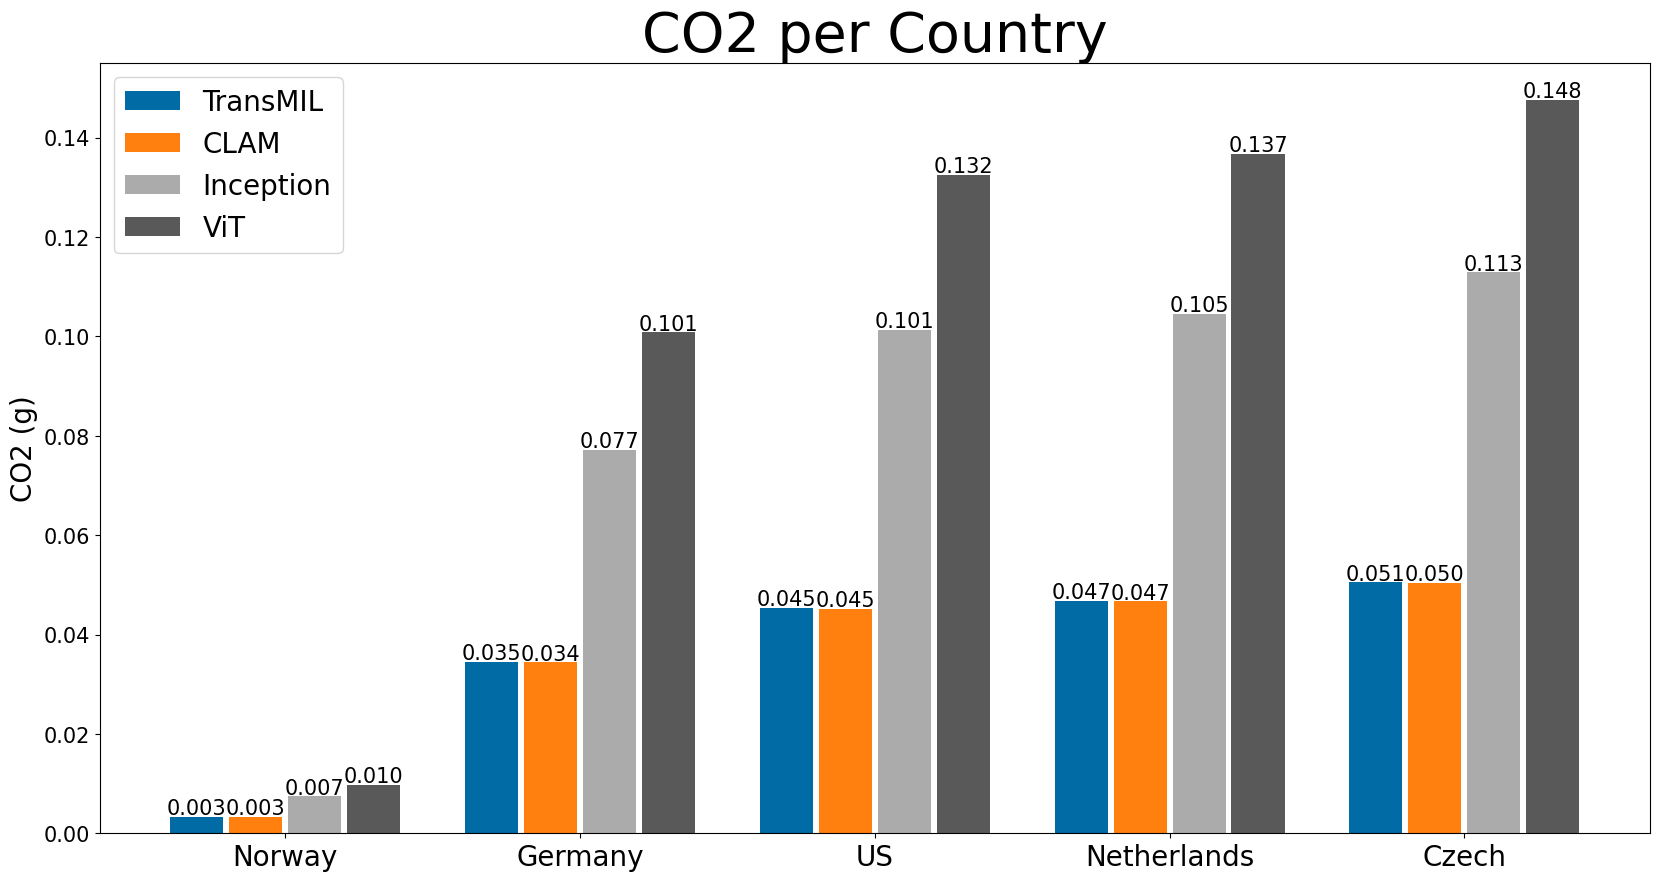

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Norway 0.942
TransMIL 0.5821633817572263
Germany 0.399
TransMIL 0.582110786010748
US 0.21
TransMIL 0.5820924803187915
Netherlands 0.185
TransMIL 0.5820900589740757
Czech 0.12
TransMIL 0.5820837635249526
Norway 0.942
CLAM 0.556516
Germany 0.399
CLAM 0.556516
US 0.21
CLAM 0.556516
Netherlands 0.185
CLAM 0.556516
Czech 0.12
CLAM 0.556516
Norway 0.942
Inception 0.3258385147492058
Germany 0.399
Inception 0.31350731833677364
US 0.21
Inception 0.30932564335864876
Netherlands 0.185
Inception 0.30877670485345515
Czech 0.12
Inception 0.3073540195071825
Norway 0.942
ViT 0.529496101608949
Germany 0.399
ViT 0.4986646318297815
US 0.21
ViT 0.48835987913030643
Netherlands 0.185
ViT 0.48701285939935285
Czech 0.12
ViT 0.4835279706967817
ktx
[0.763, 0.746, 0.572, 0.73]
{'TransMIL': [0.5821633817572263, 0.582110786010748, 0.5820924803187915, 0.5820900589740757, 0.5820837635249526], 'CLAM': [0.556516, 0.556516, 0.556516, 0.556516, 0.556516], 'Inception': [0.3258385147492058, 0.31350731833677364, 0.30932564

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

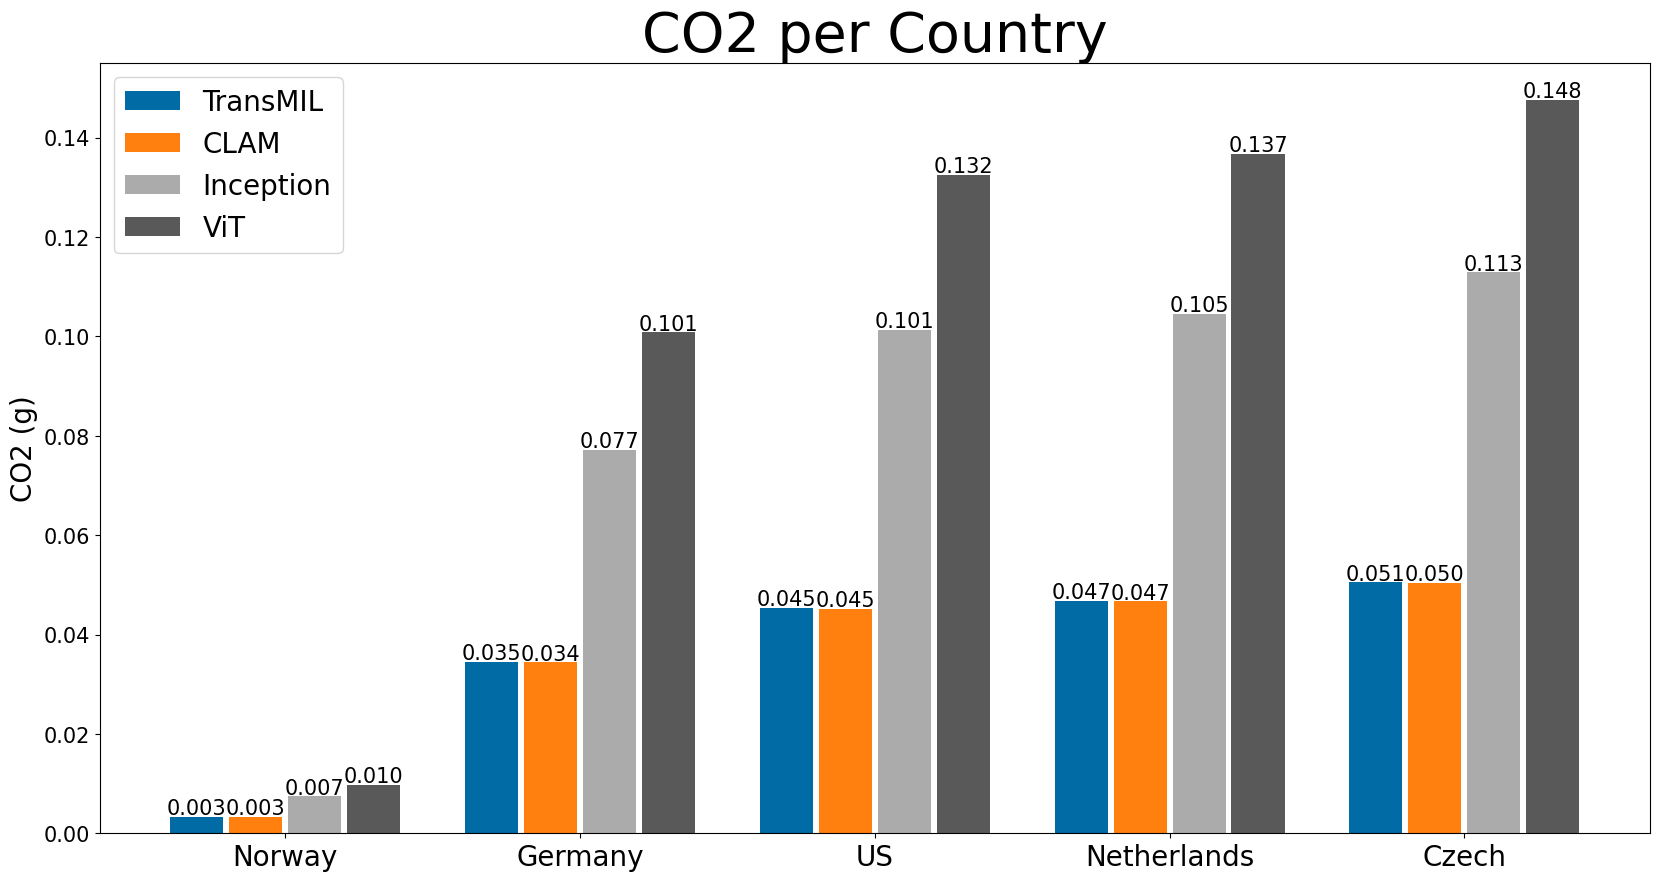

In [46]:
## Bar plot of each model for each country, compare how model scores change with energy mix



tasks = ['Normal vs Disease', 'Rejection vs Other', 'Normal vs Rejection vs Other']
# from cycler import cycler
tasks = ['big_three', 'norm_rej_rest']
tasks = ['rcc', 'ktx']


# print(len(esper_out_df.index))
line_styles = ['o-','o--','o:','o-.']
# print(esper_out_df)
# for t in tasks:

co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
co2_df = pd.read_csv(co2_path)
# print(co2_df)
# if project == 'RCC':
#     co2_df = 
# pprint(co2_df)
### GET AUC FROM CSV ###
auc_df_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_AUC.csv'
auc_df = pd.read_csv(auc_df_path)
print(auc_df)

# print(min_co2)
# print(max_co2)
for t in tasks:
    esper_dict = {}
    co2_dict = {}

    for m,p in zip(list(auc_df['MODEL']), list(auc_df[t])):
        esper_dict[m] = []
        co2_dict[m] = []
        for c in country_list:

            
            c_renRatio = re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0]

            model_co2 = co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] * ((1-c_renRatio)/(1-ger_renRatio))
            min_co2 = min(list(co2_df.CO2eq))* ((1-c_renRatio)/(1-ger_renRatio))
            max_co2 = max(list(co2_df.CO2eq))* ((1-c_renRatio)/(1-ger_renRatio))
            # min_co2 = min_co2 * ((1-c_renRatio)/(1-ger_renRatio))
            # print(c)
            print(c, c_renRatio)

            if t == 'big_three':
                model_co2 = model_co2/3
                min_co2 = min_co2/3
                max_co2 = max_co2/3
            
            # print(model_co2)
            # print(min_co2)
            
            # print('CO2 norm: ', ((model_co2 - min_co2) / (max_co2 - min_co2)))

            esper = get_ESPer(p, model_co2, min_co2)
            print(m, esper)
            esper_dict[m].append(esper)
            co2_dict[m].append(model_co2)
    print(t)
    print(list(auc_df[t]))
    print(esper_dict)
    esper_dict.pop('PALM', None)
    co2_dict.pop('PALM', None)
    
    plt.style.use('tableau-colorblind10')
    # with plt.style.context(['science', 'nature']):

    fig, ax = plt.subplots(figsize=(20,10))
    # bar_plot(ax, esper_dict, total_width=.8, single_width=.9)
    bar_plot(ax, co2_dict, total_width=.8, single_width=.9)
    # ax.set_xticklabels(country_list)
    plt.xticks(range(len(country_list)), country_list)

    plt.title('CO2 per Country', fontsize=40)
    plt.ylabel('CO2 (g)', fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=15)

    plt.show()
    plt.close()

In [47]:
### Get patch numbers / slide 

data_root = '/homeStor1/ylan/data/DeepGraft/224_256uM_annotated'
cohorts = ['DEEPGRAFT_RU', 'DEEPGRAFT_RA', 'Aachen_Biopsy_Slides_extended']
# cohorts = ['Aachen_Biopsy_Slides_extended']
dir_sizes = []
for c in cohorts:
    c_dir_sizes = []

    block_path = Path(data_root) / c / 'BLOCKS'
    for slide_path in block_path.iterdir():
        n = len(list(slide_path.glob('*')))
        c_dir_sizes.append(n)
    dir_sizes.append(c_dir_sizes)
# counts, bins = np.histogram(dir_sizes)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

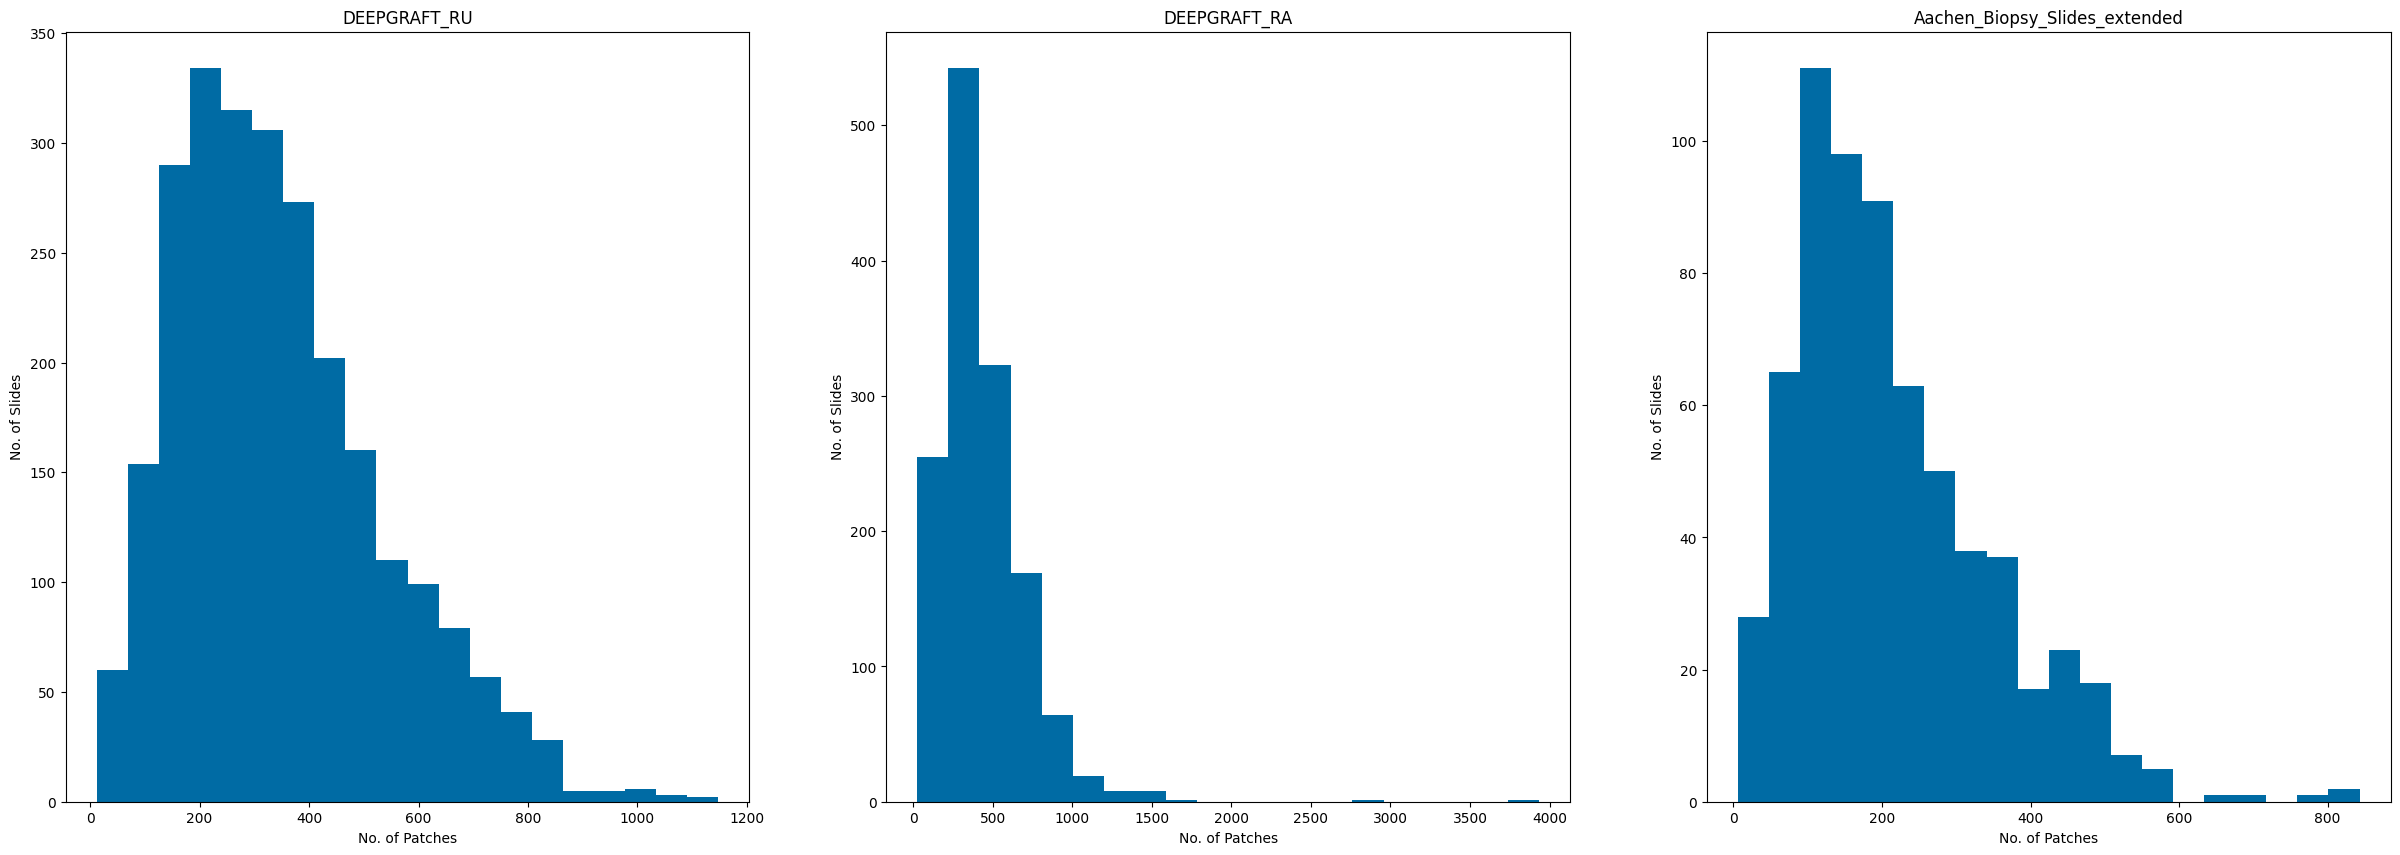

In [48]:
new_dir_sizes = []
for i in dir_sizes:
    temp = [x for x in i if x != 0]
    new_dir_sizes.append(temp)

fig, axs = plt.subplots(1,len(cohorts), figsize=(len(cohorts)*10,10))
for i in range(len(cohorts)):
    if len(cohorts)>1:
        axs[i].hist(new_dir_sizes[i], bins=20)
        axs[i].set_title(cohorts[i])
        axs[i].set_xlabel('No. of Patches')
        axs[i].set_ylabel('No. of Slides')
    else:
        axs.hist(new_dir_sizes[i], bins=20)
        axs.set_title(cohorts[i])
        axs.set_xlabel('No. of Patches')
        axs.set_ylabel('No. of Slides')

# plt.stairs(counts, bins)
# plt.hist(dir_sizes, bins=)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

[1674 1954  715  189]
[   0  250  500  750 1000]
1674
(4576,)


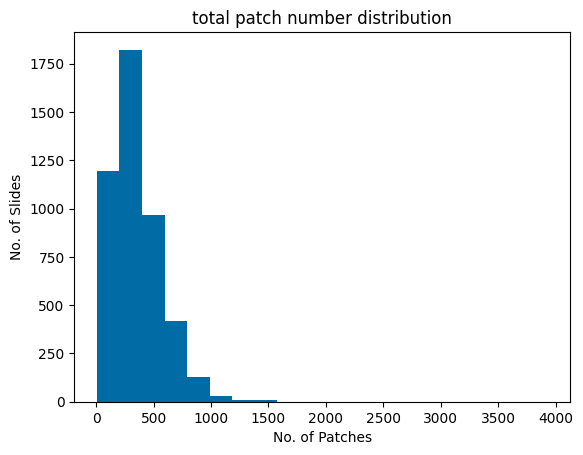

In [49]:
import itertools

total_dir_sizes = np.array(list(itertools.chain(*new_dir_sizes)))

hist, bins = np.histogram(total_dir_sizes, bins=np.arange(0, 1250, 250))
print(hist)
print(bins)
print(len(total_dir_sizes[total_dir_sizes<250]))
# print(np.array(dir_sizes).shape)
# total_dir_sizes = np.array(dir_sizes).flatten()
print(total_dir_sizes.shape)
fig, axs = plt.subplots()
axs.hist(total_dir_sizes, bins=20)
axs.set_title('total patch number distribution')
axs.set_xlabel('No. of Patches')
axs.set_ylabel('No. of Slides')

# plt.stairs(counts, bins)
# plt.hist(dir_sizes, bins=)
plt.show()

In [50]:
import statistics
# sum(total_dir_sizes)/len(total_dir_sizes)
statistics.median(total_dir_sizes)

316.0

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

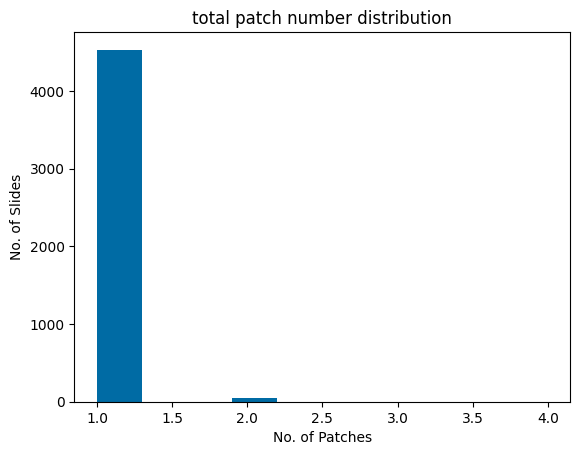

In [51]:
np.sort(total_dir_sizes)
# 2100%1000
co2eq = [x//1000 if x%1000 == 0 else (x//1000)+1 for x in total_dir_sizes]
# print(co2eq)
fig, axs = plt.subplots()

axs.hist(co2eq, bins=10)
axs.set_title('total patch number distribution')
axs.set_xlabel('No. of Patches')
axs.set_ylabel('No. of Slides')

# plt.stairs(counts, bins)
# plt.hist(dir_sizes, bins=)
plt.show()
# for i in total_dir_sizes: 
#     r = i % 1000
#     print(r)

In [52]:
model_range_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_range.csv'
model_range_df = pd.read_csv(model_range_path)
# model_range_df.to_csv(model_range_path, index=False)
len(total_dir_sizes)

4576

In [53]:
model_range_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_range.csv'
model_range_df = pd.read_csv(model_range_path)
# model_range_df.to_csv(model_range_path, index=False)
len(total_dir_sizes)
# model_range_df
# print(model_range_df)
borders = [250, 500, 750, 1000]
# slide_num_dict = {}
min_model_co2 = list(model_range_df['250'])
max_model_co2= list(model_range_df['1000'])
mean_model_co2 = []
models = ['TransMIL', 'CLAM', 'Inception', 'ViT']
for m in models:
    mean_temp = 0
    for i in range(len(borders)):
        slide_num = hist[i]
        model_range = model_range_df.loc[model_range_df.MODEL == m][str(borders[i])].values[0]
        slide_co2 = model_range*slide_num
        # mean_temp.append(slide_co2)
        mean_temp += slide_co2
    mean_model_co2.append(mean_temp / len(total_dir_sizes))
    # model_co2_dict[m].append(min_co2)
print(min_model_co2)
print(max_model_co2)
print(mean_model_co2)

d = {'MODEL':models, 'low_co2': min_model_co2, 'mean_co2': mean_model_co2, 'high_co2': max_model_co2}
df = pd.DataFrame(data=d)
df.to_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')


rcc_aucs = []
ktx_aucs = []
        # print(m, model_range*slide_num) #model_range * slide_num -> co2eq depending on patch_number in slide
        

[0.00246, 0.00266, 0.0068, 0.0038]
[0.014, 0.013, 0.0188, 0.0185]
[0.006798347902097902, 0.006006368006993007, 0.01164429632867133, 0.007828649475524474]


In [54]:
model_auc_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_AUC.csv'
model_auc_df = pd.read_csv(model_auc_path)

ktx_auc_list = list(model_auc_df['ktx'])
rcc_auc_list = list(model_auc_df['rcc'])
print(ktx_auc_list)
print(rcc_auc_list)



min_esper = [get_ESPer(auc, co2eq=3*x, co2eq_min=min(min_model_co2)) for auc, x in zip(ktx_auc_list, min_model_co2)]
max_esper = [get_ESPer(auc, co2eq=3*x, co2eq_min=min(max_model_co2)) for auc, x in zip(ktx_auc_list, max_model_co2)]
mean_esper = [get_ESPer(auc, co2eq=3*x, co2eq_min=min(mean_model_co2)) for auc, x in zip(ktx_auc_list, mean_model_co2)]

# for p in ['rcc', 'ktx']:
#     aucs = model_auc_df.loc[model_auc_df[p]]
# print(min_esper)
# print(max_esper)
# print(mean_esper)

min_co2 = min(mean_model_co2) *3
esper = [get_ESPer(auc, 3*x, min_co2) for auc, x in zip(ktx_auc_list, mean_model_co2)]
# print(mean_model_co2)
# pprint(esper)

    

[0.763, 0.746, 0.572, 0.73]
[0.9776798288027444, 0.7794574697812399, 0.8932955265045166, 0.8776348034540812]


In [61]:
# mean_esper = [get_ESPer(auc, co2eq=3*x, co2eq_min=3*min(mean_model_co2)) for auc, x in zip(ktx_auc_list, mean_model_co2)]
mean_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(mean_model_co2)) for auc, x in zip(rcc_auc_list, mean_model_co2)]
print(mean_esper)

[0.9551011271431145, 0.6075539471977724, 0.7934906196619592, 0.768840527065276]


In [55]:
renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)
re_ratio.sort_values(by=['renewableRatio'], inplace=True)

country_list = list(re_ratio.Country)
germany_ratio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
ratio_list = [germany_ratio/re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for c in country_list]


In [56]:
ratio_list

[5.115384615384616,
 3.325,
 3.022727272727273,
 2.156756756756757,
 1.9368932038834954,
 1.8732394366197185,
 1.4301075268817203,
 1.33,
 1.1465517241379313,
 1.0283505154639176,
 1.0,
 0.9827586206896551,
 0.7823529411764706,
 0.7808219178082192,
 0.5973053892215568,
 0.4235668789808918]

In [57]:
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'


def plot_confidence_interval(x, mean, lower_bound, higher_bound, ax, color='#2187bb', horizontal_line_width=0.25):
    # mean = statistics.mean(values)
    # stdev = statistics.stdev(values)
    # confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = higher_bound
    right = x + horizontal_line_width / 2
    bottom = lower_bound
    ax.plot([x, x], [top, bottom], color=color, linewidth=10)
    ax.plot([left, right], [top, top], color=color, linewidth=10)
    ax.plot([left, right], [bottom, bottom], color=color, linewidth=10)
    ax.plot(x, mean, 'o', color=color, markersize=30)

    return 



plt.rcParams["font.family"] = "Arial"

renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)
re_ratio.sort_values(by=['renewableRatio'], inplace=True)

country_list = list(re_ratio.Country)
germany_ratio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
ratio_list = [germany_ratio/re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for c in country_list]

# df.to_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
co2_range_df = pd.read_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
mean_model_co2 = co2_range_df['mean_co2']
low_model_co2 = co2_range_df['low_co2']
high_model_co2 = co2_range_df['high_co2']


COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=10)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
line_styles = ['o-','o--','o:','o-.', 'o-']



with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(10,10)) #
    legend_list = []
    # for i, model in enumerate(model_list): #
    # model_list = ['TransMIL', 'CLAM']
    x_ticks = np.arange(len(model_list), dtype=int)
    for i, model in enumerate(model_list): #

        color = COLOR_MAP[i]
        # low_kill_list = [mortality_2032(model, x)[0] for x in ratio_list]
        # high_kill_list = [mortality_2032(model, x)[1] for x in ratio_list]
        # mean_kill_list = np.mean(np.array([low_kill_list, high_kill_list]), axis=0)
        # sorted_indices = np.argsort(-mean_kill_list)
        # low_y = [low_kill_list[i] for _, i in zip(low_kill_list, sorted_indices)]
        # high_y = [high_kill_list[i] for _, i in zip(high_kill_list, sorted_indices)]
        # mean_y = [mean_kill_list[i] for _, i in zip(mean_kill_list, sorted_indices)]


        # x = [country_list[i] for _, i in zip(country_list, sorted_indices)]
        # auc = ktx_auc_list[i]
        # auc = rcc_auc_list[i]
        # print(auc)
        # min_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(min_model_co2)) for auc, x in zip(ratio_list, min_model_co2)]
        # max_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(max_model_co2)) for auc, x in zip(ktx_auc_list, max_model_co2)]
        # mean_esper = [get_ESPer(auc, co2eq=3*x*ratio_list, co2eq_min=min(mean_model_co2)) for auc, x in zip(ratio_list, mean_model_co2)]
        mean_co2 = mean_model_co2[i]
        low_co2 = low_model_co2[i]
        high_co2 = high_model_co2[i]

        
        # mean_co2 = [mean_model_co2[i]*r for r in ratio_list]
        # low_co2 = [low_model_co2[i]*r for r in ratio_list]
        # high_co2 = [high_model_co2[i]*r for r in ratio_list]
        # min_esper = [get_ESPer(auc, co2eq=min_model_co2[i]*r, co2eq_min=min(min_model_co2)) for r in ratio_list]
        # max_esper = [get_ESPer(auc, co2eq=max_model_co2[i]*r, co2eq_min=min(max_model_co2)) for r in ratio_list]

        # mean_esper = [get_ESPer(auc, co2eq=3*mean_model_co2[i]*r, co2eq_min=min(mean_model_co2)*3) for r in ratio_list]
        # min_esper = [get_ESPer(auc, co2eq=3*min_model_co2[i]*r, co2eq_min=min(min_model_co2)*3) for r in ratio_list]
        # max_esper = [get_ESPer(auc, co2eq=3*max_model_co2[i]*r, co2eq_min=min(max_model_co2)*3) for r in ratio_list]
        
        # x = [mi] for _, i in zip(country_list, sorted_indices)]
        # ax.grid(visible=True, which='major', axis='x')
        # ax.set_xticklabels([])
        
        # x = model_list
        # x = country_list

        
        # p, = ax.plot(x, mean_co2, 'o-', color=color, linewidth=3)
        plot_confidence_interval(i, mean_co2, low_co2, high_co2, ax=ax, color=COLOR_MAP[i])
        
        # ax.fill_between(x, low_co2, high_co2, color=color, alpha=.15)
        # ax.grid(visible=True, which='major', axis='x')
        # ax.set_xticklabels([])
        # p, = ax.plot(x, mean_esper, 'o-', color=color)
        # ax.fill_between(x, min_esper, max_esper, color=color, alpha=.15)
        # addlabels(x, y)
        # ax.legend(model, fontsize=20)
        # legend_list.append(p)
    ax.text(0+0.15, mean_model_co2[0], 'MEAN', va='center_baseline', ha='left', fontsize=20)
    ax.text(0+0.20, max_model_co2[0], 'MAX', va='center_baseline', ha='left', fontsize=20)
    ax.text(0+0.20, min_model_co2[0], 'MIN', va='center_baseline', ha='left', fontsize=20)
    # plt.ylim([0.0, 1.0])
    plt.legend(legend_list, model_list, fontsize=30, loc='upper right')
    # plt.grid(visible=True, which='major', axis='x')
    plt.ylabel('CO2eq (g)', fontsize= 30)
    plt.xticks(x_ticks, model_list, fontsize=30)
    # plt.xticks([])
    # plt.grid(visible=True, which='major', axis='x')

        # ax[0].set_xticks([])

    # plt.xticks(rotation=45, ha='right', fontsize=20)

    plt.yticks(fontsize=30)
    # plt.xticks(ha='right', fontsize=20)
    # plt.title(f'ESPer with lower and upper bound', fontsize=40)
    plt.title(f'CO2eq interval for each Model', fontsize=40)
    # plt.show()
    plt.tight_layout()
    # plt.savefig(f'{paper_outdir}/co2eq_interval.png', dpi=400)
    # plt.savefig(f'{paper_outdir}/co2eq_interval.svg', dpi=400)
    plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

In [ ]:
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'


def plot_confidence_interval(x, mean, lower_bound, higher_bound, ax, color='#2187bb', horizontal_line_width=0.25):
    # mean = statistics.mean(values)
    # stdev = statistics.stdev(values)
    # confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = higher_bound
    right = x + horizontal_line_width / 2
    bottom = lower_bound
    ax.plot([x, x], [top, bottom], color=color, linewidth=3)
    ax.plot([left, right], [top, top], color=color, linewidth=3)
    ax.plot([left, right], [bottom, bottom], color=color, linewidth=3)
    ax.plot(x, mean, 'o', color='#f44336', markersize=10)

    return 



plt.rcParams["font.family"] = "Arial"

renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)
re_ratio.sort_values(by=['renewableRatio'], inplace=True)

country_list = list(re_ratio.Country)
germany_ratio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
ratio_list = [germany_ratio/re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for c in country_list]

# df.to_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
co2_range_df = pd.read_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
mean_model_co2 = co2_range_df['mean_co2']
low_model_co2 = co2_range_df['low_co2']
high_model_co2 = co2_range_df['high_co2']

COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=10)
model_list = ['TransMIL', 'CLAM', 'InceptionNet', 'ViT']
line_styles = ['o-','o--','o:','o-.', 'o-']

# with plt.style.context(['science', 'nature']):
fig, ax = plt.subplots(figsize=(10,10)) #
legend_list = []
x_ticks = np.arange(len(model_list), dtype=int)


rcc_mean_co2 = [get_ESPer(rcc_auc_list[i], co2eq=mean_model_co2[i], co2eq_min=min(mean_model_co2))  for i in range(len(model_list))]

p, = ax.plot(x_ticks, rcc_mean_co2, 'o--', color='black', linewidth=5)
legend_list.append(p)

ktx_mean_co2 = [get_ESPer(ktx_auc_list[i], co2eq=mean_model_co2[i], co2eq_min=min(mean_model_co2))  for i in range(len(model_list))]
p, = ax.plot(x_ticks, ktx_mean_co2, 'o:', color='black', linewidth=5)

legend_list.append(p)

for i in range(len(model_list)):
    ax.plot([i,i], [rcc_mean_co2[i], ktx_mean_co2[i]], 'o-', ms=30, linewidth=10, color=COLOR_MAP[i])



ax.set_ylabel('ESPer Score', fontsize= 30)
ax.set_xticks(x_ticks, model_list, fontsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)
plt.legend(legend_list, ['RCC', 'KTX'], fontsize=30, loc='upper right')
fig.suptitle(f'ESPer Scores for each task', fontsize=40)
# plt.show()
plt.tight_layout()
# plt.savefig(f'{paper_outdir}/esper_interval.png', dpi=400)
# plt.savefig(f'{paper_outdir}/esper_interval.svg', dpi=400)
plt.show()
print(rcc_mean_co2)
print(ktx_mean_co2)

NameError: name 'rcc_auc_list' is not defined

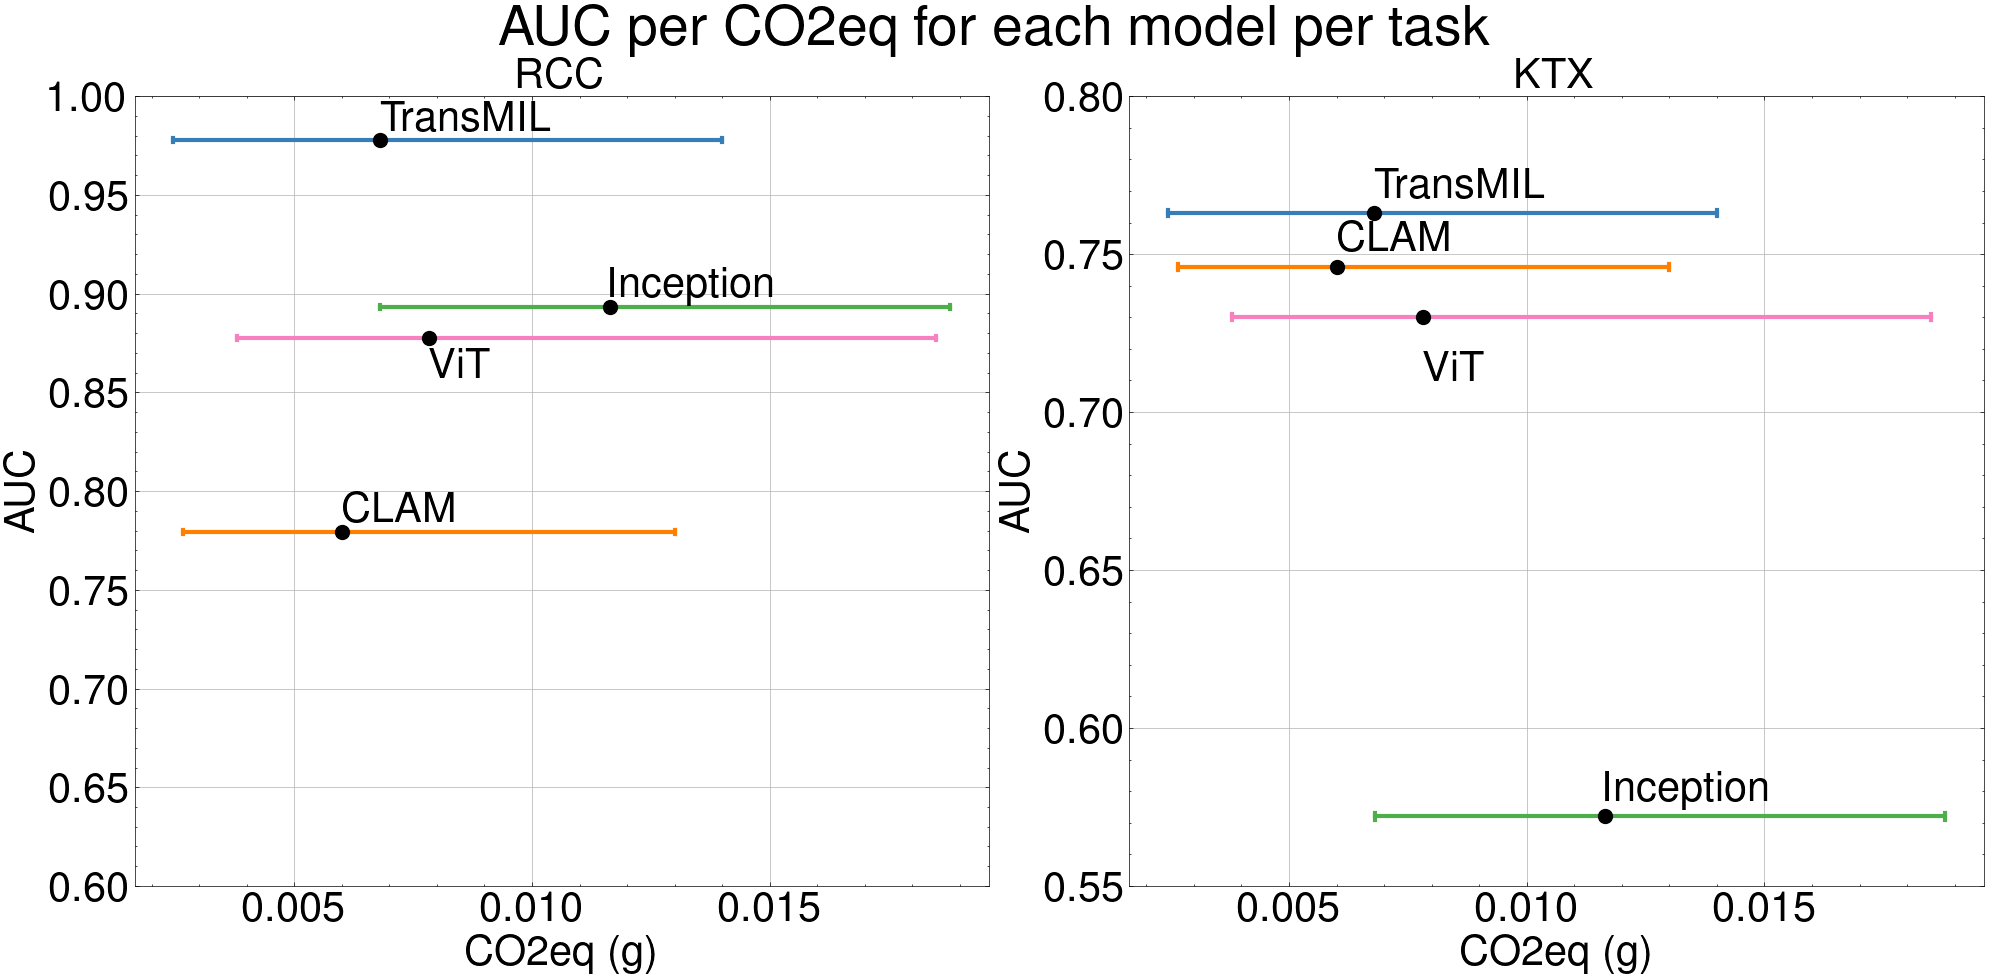

In [ ]:
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'


def plot_confidence_interval_horizontal(x, mean, lower_bound, higher_bound, ax, label, label_position='up', color='#2187bb', horizontal_line_width=0.25):
    # mean = statistics.mean(values)
    # stdev = statistics.stdev(values)
    # confidence_interval = z * stdev / sqrt(len(values))

    bottom = x - 0.001
    top = x + 0.001

    # up = 
    right = higher_bound
    left = lower_bound
    ax.plot([left, right], [x, x], color=color, linewidth=3)
    ax.plot([left, left], [bottom, top], color=color, linewidth=3)
    ax.plot([right, right], [bottom, top], color=color, linewidth=3)
    # ax.plot(mean, x, 'o', color='#f44336', markersize=10)
    ax.plot(mean, x, 'o', color='black', markersize=10)
    if label_position == 'up':
        ax.text(mean, x+0.005, label, fontsize=30)
    elif label_position == 'down':
        ax.text(mean, x-0.02, label, fontsize=30)


    return 



plt.rcParams["font.family"] = "Arial"

renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)
re_ratio.sort_values(by=['renewableRatio'], inplace=True)

country_list = list(re_ratio.Country)
germany_ratio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
ratio_list = [germany_ratio/re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for c in country_list]

# df.to_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
co2_range_df = pd.read_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
mean_model_co2 = co2_range_df['mean_co2']
low_model_co2 = co2_range_df['low_co2']
high_model_co2 = co2_range_df['high_co2']


COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=10)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
line_styles = ['o-','o--','o:','o-.', 'o-']



with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(1,2, figsize=(20,10)) #
    legend_list = []
    # for i, model in enumerate(model_list): #
    # model_list = ['TransMIL', 'CLAM']
    x_ticks = np.arange(len(model_list), dtype=int)
    for i, model in enumerate(model_list): #

        color = COLOR_MAP[i]
        # low_kill_list = [mortality_2032(model, x)[0] for x in ratio_list]
        # high_kill_list = [mortality_2032(model, x)[1] for x in ratio_list]
        # mean_kill_list = np.mean(np.array([low_kill_list, high_kill_list]), axis=0)
        # sorted_indices = np.argsort(-mean_kill_list)
        # low_y = [low_kill_list[i] for _, i in zip(low_kill_list, sorted_indices)]
        # high_y = [high_kill_list[i] for _, i in zip(high_kill_list, sorted_indices)]
        # mean_y = [mean_kill_list[i] for _, i in zip(mean_kill_list, sorted_indices)]


        # x = [country_list[i] for _, i in zip(country_list, sorted_indices)]
        rcc_auc = rcc_auc_list[i]
        # print(rcc_auc)
        # print(mean_model_co2[i])
        # print(min(mean_model_co2))
        # rcc_mean_co2 = get_ESPer(rcc_auc, co2eq=mean_model_co2[i], co2eq_min=min(mean_model_co2))
        # rcc_low_co2 = get_ESPer(rcc_auc, co2eq=low_model_co2[i], co2eq_min=min(low_model_co2))
        # rcc_high_co2 = get_ESPer(rcc_auc, co2eq=high_model_co2[i], co2eq_min=min(high_model_co2))
        # mean_co2 = 
        mean_co2 = mean_model_co2[i]
        low_co2 = low_model_co2[i]
        high_co2 = high_model_co2[i]

        if model == 'ViT':
            plot_confidence_interval_horizontal(rcc_auc, mean_co2, low_co2, high_co2, ax=ax[0], label=model, label_position='down', color=color)
        else:
            plot_confidence_interval_horizontal(rcc_auc, mean_co2, low_co2, high_co2, ax=ax[0], label=model, color=color)




        ktx_auc = ktx_auc_list[i]
        # auc = rcc_auc_list[i]
        # print(auc)
        # min_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(min_model_co2)) for auc, x in zip(ratio_list, min_model_co2)]
        # max_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(max_model_co2)) for auc, x in zip(ktx_auc_list, max_model_co2)]
        # mean_esper = [get_ESPer(auc, co2eq=3*x*ratio_list, co2eq_min=min(mean_model_co2)) for auc, x in zip(ratio_list, mean_model_co2)]
        # mean_co2 = get_ESPer(ktx_auc, co2eq=3*mean_model_co2[i], co2eq_min=3*min(mean_model_co2))
        # low_co2 = get_ESPer(ktx_auc, co2eq=3*low_model_co2[i], co2eq_min=3*min(low_model_co2))
        # high_co2 = get_ESPer(ktx_auc, co2eq=3*high_model_co2[i], co2eq_min=3*min(high_model_co2))
        if model == 'ViT':
            plot_confidence_interval_horizontal(ktx_auc, mean_co2, low_co2, high_co2, ax=ax[1], label=model, label_position='down', color=color)
        else:
            plot_confidence_interval_horizontal(ktx_auc, mean_co2, low_co2, high_co2, ax=ax[1], label=model, color=color)


    ax[0].set_title('RCC', fontsize=30)
    ax[0].set_ylabel('AUC', fontsize= 30)
    ax[0].set_xlabel('CO2eq (g)', fontsize= 30)
    # ax[0].set_xticks(x_ticks, model_list, fontsize=30)
    ax[0].tick_params(axis='y', which='major', labelsize=30)
    ax[0].tick_params(axis='x', which='major', labelsize=30)
    ax[0].set_ylim([0.6, 1.0])
    ax[0].grid(visible=True, which='major', axis='y')
    ax[0].grid(visible=True, which='major', axis='x')



    
    ax[1].set_title('KTX', fontsize=30)
    ax[1].set_ylabel('AUC', fontsize= 30)

    ax[1].set_xlabel('CO2eq (g)', fontsize= 30)
    ax[1].tick_params(axis='y', which='major', labelsize=30)

    ax[1].tick_params(axis='x', which='major', labelsize=30)

    # ax[1].set_xticks(x_ticks, model_list, fontsize=30)
    # ax[1].tick_params(axis='y', which='major', labelsize=30)
    # ax[1].set_yticks([])
    ax[1].set_ylim([0.55, 0.8])
    ax[1].grid(visible=True, which='major', axis='y')
    ax[1].grid(visible=True, which='major', axis='x')


    

            
    # plt.ylim([0.0, 1.0])
    # plt.legend(legend_list, model_list, fontsize=30, loc='upper right')
    # plt.grid(visible=True, which='major', axis='x')
    # plt.ylabel('CO2eq (g)', fontsize= 30)
    # plt.xticks(x_ticks, model_list, fontsize=30)
    # plt.xticks([])
    # plt.grid(visible=True, which='major', axis='x')

        # ax[0].set_xticks([])

    # plt.xticks(rotation=45, ha='right', fontsize=20)

    # plt.xticks(ha='right', fontsize=20)
    # plt.title(f'ESPer with lower and upper bound', fontsize=40)
    fig.suptitle(f'AUC per CO2eq for each model per task', fontsize=40)
    # plt.show()
    plt.tight_layout()
    # plt.savefig(f'{paper_outdir}/esper_interval.png', dpi=400)
    # plt.savefig(f'{paper_outdir}/esper_interval.svg', dpi=400)
    plt.show()

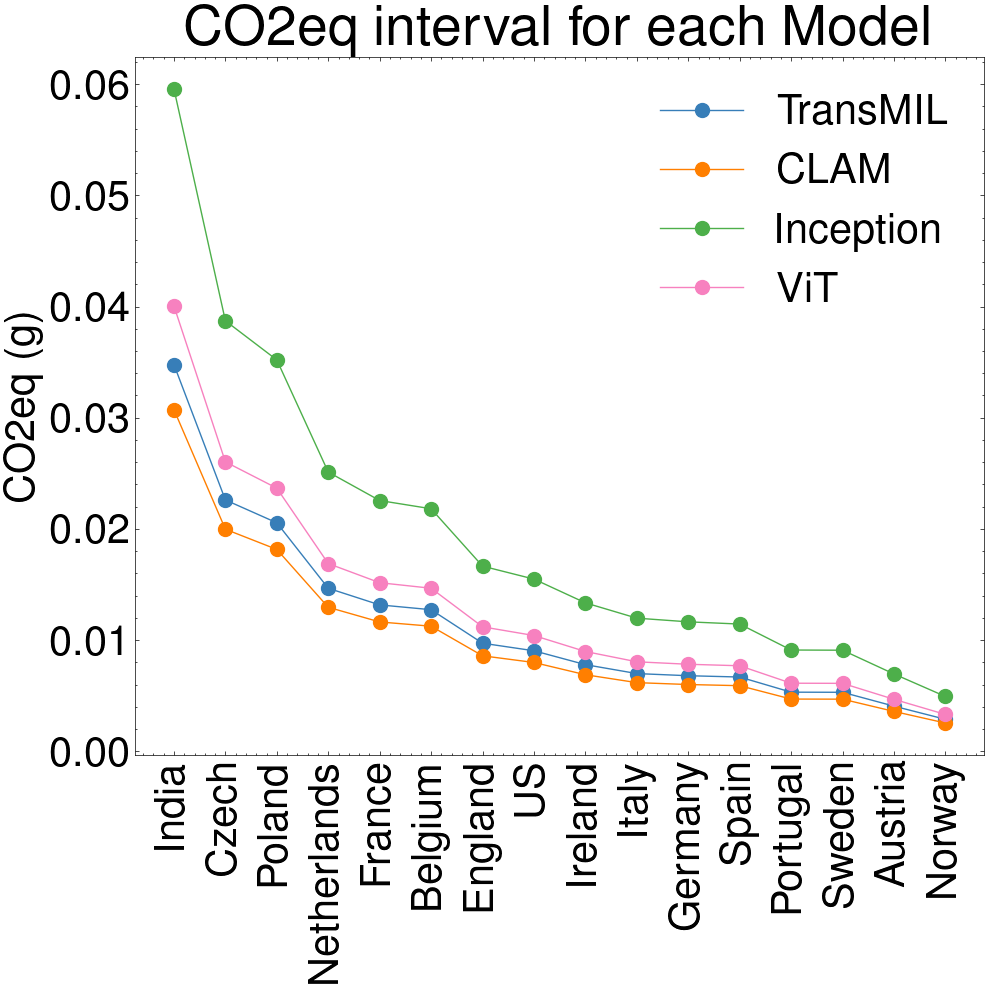

In [ ]:
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'


def plot_confidence_interval(x, mean, lower_bound, higher_bound, ax, color='#2187bb', horizontal_line_width=0.25):
    # mean = statistics.mean(values)
    # stdev = statistics.stdev(values)
    # confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = higher_bound
    right = x + horizontal_line_width / 2
    bottom = lower_bound
    ax.plot([x, x], [top, bottom], color=color, linewidth=3)
    ax.plot([left, right], [top, top], color=color, linewidth=3)
    ax.plot([left, right], [bottom, bottom], color=color, linewidth=3)
    ax.plot(x, mean, 'o', color='#f44336', markersize=10)

    return 



plt.rcParams["font.family"] = "Arial"

renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)
re_ratio.sort_values(by=['renewableRatio'], inplace=True)

country_list = list(re_ratio.Country)
germany_ratio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
ratio_list = [germany_ratio/re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for c in country_list]

# df.to_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
co2_range_df = pd.read_csv('/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_upper_lower.csv')
mean_model_co2 = co2_range_df['mean_co2']
low_model_co2 = co2_range_df['low_co2']
high_model_co2 = co2_range_df['high_co2']


COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, f'{y[i]:.2f}', ha = 'center', fontsize=10)
model_list = ['TransMIL', 'CLAM', 'Inception', 'ViT']
line_styles = ['o-','o--','o:','o-.', 'o-']



with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(10,10)) #
    legend_list = []
    # for i, model in enumerate(model_list): #
    # model_list = ['TransMIL', 'CLAM']
    x_ticks = np.arange(len(country_list), dtype=int)
    for i, model in enumerate(model_list): #

        color = COLOR_MAP[i]
        # low_kill_list = [mortality_2032(model, x)[0] for x in ratio_list]
        # high_kill_list = [mortality_2032(model, x)[1] for x in ratio_list]
        # mean_kill_list = np.mean(np.array([low_kill_list, high_kill_list]), axis=0)
        # sorted_indices = np.argsort(-mean_kill_list)
        # low_y = [low_kill_list[i] for _, i in zip(low_kill_list, sorted_indices)]
        # high_y = [high_kill_list[i] for _, i in zip(high_kill_list, sorted_indices)]
        # mean_y = [mean_kill_list[i] for _, i in zip(mean_kill_list, sorted_indices)]


        # x = [country_list[i] for _, i in zip(country_list, sorted_indices)]
        # auc = ktx_auc_list[i]
        # auc = rcc_auc_list[i]
        # print(auc)
        # min_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(min_model_co2)) for auc, x in zip(ratio_list, min_model_co2)]
        # max_esper = [get_ESPer(auc, co2eq=x, co2eq_min=min(max_model_co2)) for auc, x in zip(ktx_auc_list, max_model_co2)]
        # mean_esper = [get_ESPer(auc, co2eq=3*x*ratio_list, co2eq_min=min(mean_model_co2)) for auc, x in zip(ratio_list, mean_model_co2)]
        # mean_co2 = mean_model_co2[i]
        # low_co2 = low_model_co2[i]
        # high_co2 = high_model_co2[i]
        mean_co2 = [mean_model_co2[i]*r for r in ratio_list]
        low_co2 = [low_model_co2[i]*r for r in ratio_list]
        high_co2 = [high_model_co2[i]*r for r in ratio_list]
        # min_esper = [get_ESPer(auc, co2eq=min_model_co2[i]*r, co2eq_min=min(min_model_co2)) for r in ratio_list]
        # max_esper = [get_ESPer(auc, co2eq=max_model_co2[i]*r, co2eq_min=min(max_model_co2)) for r in ratio_list]

        # mean_esper = [mean_model_co2[i]*r for r in ratio_list]
        # min_esper = [get_ESPer(auc, co2eq=3*min_model_co2[i]*r, co2eq_min=min(min_model_co2)*3) for r in ratio_list]
        # max_esper = [get_ESPer(auc, co2eq=3*max_model_co2[i]*r, co2eq_min=min(max_model_co2)*3) for r in ratio_list]
        
        # x = [mi] for _, i in zip(country_list, sorted_indices)]
        # ax.grid(visible=True, which='major', axis='x')
        # ax.set_xticklabels([])
        
        # x = model_list
        x = country_list

        
        p, = ax.plot(x, mean_co2, 'o-', color=color, ms=10)
        # plot_confidence_interval(i, mean_co2, low_co2, high_co2, ax=ax)
        # ax.fill_between(x, low_co2, high_co2, color=color, alpha=.15)
        # ax.grid(visible=True, which='major', axis='x')
        # ax.set_xticklabels([])
        # p, = ax.plot(x, mean_esper, 'o-', color=color)
        # ax.fill_between(x, min_esper, max_esper, color=color, alpha=.15)
        # addlabels(x, y)
        # ax.legend(model, fontsize=20)
        legend_list.append(p)
            
    # plt.ylim([0.0, 1.0])
    plt.legend(legend_list, model_list, fontsize=30, loc='upper right')
    # plt.grid(visible=True, which='major', axis='x')
    plt.ylabel('CO2eq (g)', fontsize= 30)
    plt.xticks(x_ticks, country_list, rotation=90, ha='center', fontsize=30)
    # plt.xticks([])
    # plt.grid(visible=True, which='major', axis='x')

        # ax[0].set_xticks([])

    # plt.xticks(rotation=45, ha='right', fontsize=20)

    plt.yticks(fontsize=30)
    # plt.xticks(ha='right', fontsize=20)
    # plt.title(f'ESPer with lower and upper bound', fontsize=40)
    plt.title(f'CO2eq interval for each Model', fontsize=40)
    # plt.show()
    plt.tight_layout()
    # plt.savefig(f'{paper_outdir}/co2eq_interval.png', dpi=400)
    # plt.savefig(f'{paper_outdir}/co2eq_interval.svg', dpi=400)
    plt.show()